In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import mode


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
data = pd.read_csv('/Users/philip_cho/Desktop/df1_loan 2.csv')
data.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         500 non-null    int64  
 1   Loan_ID            500 non-null    object 
 2   Gender             491 non-null    object 
 3   Married            497 non-null    object 
 4   Dependents         488 non-null    object 
 5   Education          500 non-null    object 
 6   Self_Employed      473 non-null    object 
 7   ApplicantIncome    500 non-null    int64  
 8   CoapplicantIncome  500 non-null    float64
 9   LoanAmount         482 non-null    float64
 10  Loan_Amount_Term   486 non-null    float64
 11  Credit_History     459 non-null    float64
 12  Property_Area      500 non-null    object 
 13  Loan_Status        500 non-null    object 
 14  Total_Income       500 non-null    object 
dtypes: float64(4), int64(2), object(9)
memory usage: 58.7+ KB


In [4]:
# input / output split + 불필요한 feature 삭제
X = data.drop(['Unnamed: 0', 'Loan_ID', 'Loan_Status'], axis=1)
y = data['Loan_Status']

# Total_Income float 변환, Credit_history object 변환
for i in range(len(X['Total_Income'])):
    X['Total_Income'][i] = X['Total_Income'][i].strip('$')
    
X['Credit_History'].fillna(mode(X['Credit_History'])[0][0], inplace=True)
X = X.astype({'Total_Income':'float', 'Credit_History':'str'})
    

In [5]:
type(X['Credit_History'][0])

str

In [6]:
# 결측치 처리1 - 평균(수치형), 최빈값(범주형) 처리
def meanMode(X):
    
    # 연속형 피처 리스트 저장
    num_col = list(X._get_numeric_data().columns)

    # 범주형 피처 리스트 저장
    cat_col = list(X.columns)
    for col in num_col:
        cat_col.remove(col)

    # 연속형 데이터 전처리(평균값으로 채우기)
    for col in num_col:
        X[col].fillna(round(np.mean(X[col])), inplace=True)

    # 범주형 데이터 전처리 (최빈값으로 채우기)
    for col in cat_col:
        X[col].fillna(mode(X[col])[0][0], inplace=True)
        
    return X
        
    
# 결측치 처리2 - 결측행 제거
def delNaN(X, y):
    X['y'] = y
    X = X.dropna(how='any', axis=0).reset_index()
    return X.drop('y', axis=1), X['y']

# 인코딩1 - 레이블인코딩
def LabelEncode(X):
    
    # 연속형 피처 리스트 저장
    num_col = list(X._get_numeric_data().columns)

    # 범주형 피처 리스트 저장
    cat_col = list(X.columns)
    for col in num_col:
        cat_col.remove(col)
        
    encoder = LabelEncoder()
    for cat in cat_col:
        X[cat] = encoder.fit_transform(X[cat])

    return X

# 인코딩2 - 원핫인코딩
def OneHotEncode(X):
    object_col = []
    for col in X.columns:
        if X[col].dtype == 'object':
            object_col.append(col)

    enc = OneHotEncoder()
    enc.fit(X.loc[:,object_col])

    onehot_X = pd.DataFrame(enc.transform(X.loc[:,object_col]).toarray(), 
                                   columns = enc.get_feature_names(object_col))
    X.drop(object_col, axis=1, inplace=True)
    X = pd.concat([X, onehot_X], axis=1)
    
    return X


# testing page

In [7]:
# X['Loan_Amount_Term'].fillna(X['Loan_Amount_Term'].mode()[0], inplace=True)
# X['LoanAmount'].fillna(X['LoanAmount'].mean(), inplace=True)

# fillna

In [8]:
# 가계 부채비율
X['DeptRatio'] = round((X['LoanAmount']*1000)/(X['Total_Income']*12),1)

# 월 이자 부담(원금 균등상환 전제)
montly_interest = round(X['LoanAmount']*1000/X['Loan_Amount_Term'])
X['MonthlyInterest'] = round(montly_interest/X['Total_Income'],2)

In [9]:
X = meanMode(X)
# X, y = delNaN(X,y)

# 파생변수

In [10]:
X['LoanYear'] = (X['Loan_Amount_Term']/12).astype(int)
X['LoanAmountThousand'] = X['LoanAmount']*1000
X['YearInterest'] = X['LoanAmountThousand']/X['LoanYear']

In [11]:
X['ApplicantIncome'] = np.log(X['ApplicantIncome'])
X['CoapplicantIncome'] = np.log(X['CoapplicantIncome'])
X['Total_Income'] = np.log(X['Total_Income'])
X['YearInterest'] = np.log(X['YearInterest'])


<AxesSubplot:>

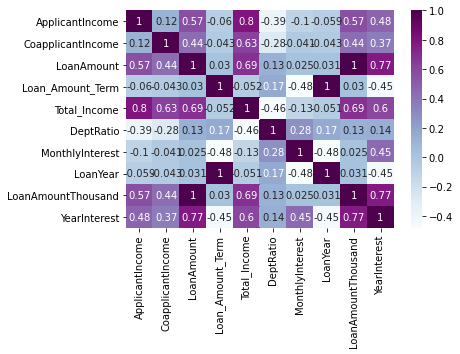

In [12]:
corr2 = X.corr()
sns.heatmap(corr2, annot=True, cmap='BuPu')

In [13]:
# X = X.drop(['LoanAmount', 'LoanAmountThousand', 'Loan_Amount_Term', 'CoapplicantIncome'],axis=1)
# X = X.drop(['LoanAmount', 'LoanAmountThousand', 'Loan_Amount_Term', 'CoapplicantIncome', 'LoanYear'],axis=1)
X = X.drop(['LoanAmountThousand', 'LoanYear', 'CoapplicantIncome'],axis=1)
# X = X.drop(['CoapplicantIncome'],axis=1)


In [14]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,DeptRatio,MonthlyInterest,YearInterest
0,Male,No,0,Graduate,No,8.674026,144.0,360.0,1.0,Urban,8.674026,2.0,0.00,8.476371
1,Male,Yes,1,Graduate,No,8.430109,128.0,360.0,1.0,Rural,8.714568,1.8,0.06,8.358588
2,Male,Yes,0,Graduate,Yes,8.006368,66.0,360.0,1.0,Urban,8.006368,1.8,0.06,7.696213
3,Male,Yes,0,Not Graduate,No,7.856707,120.0,360.0,1.0,Urban,8.505323,2.0,0.07,8.294050
4,Male,No,0,Graduate,No,8.699515,141.0,360.0,1.0,Urban,8.699515,2.0,0.07,8.455318


<AxesSubplot:>

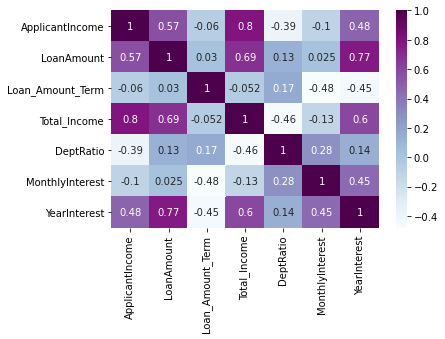

In [15]:
corr3 = X.corr()
sns.heatmap(corr3, annot=True, cmap='BuPu')

In [16]:
X = LabelEncode(X)
enc = LabelEncoder()
y = enc.fit_transform(y)

In [17]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,DeptRatio,MonthlyInterest,YearInterest
0,1,0,0,0,0,8.674026,144.0,360.0,1,2,8.674026,2.0,0.00,8.476371
1,1,1,1,0,0,8.430109,128.0,360.0,1,0,8.714568,1.8,0.06,8.358588
2,1,1,0,0,1,8.006368,66.0,360.0,1,2,8.006368,1.8,0.06,7.696213
3,1,1,0,1,0,7.856707,120.0,360.0,1,2,8.505323,2.0,0.07,8.294050
4,1,0,0,0,0,8.699515,141.0,360.0,1,2,8.699515,2.0,0.07,8.455318


In [18]:
X['Credit_History'].unique()

array([1, 0])

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            500 non-null    int64  
 1   Married           500 non-null    int64  
 2   Dependents        500 non-null    int64  
 3   Education         500 non-null    int64  
 4   Self_Employed     500 non-null    int64  
 5   ApplicantIncome   500 non-null    float64
 6   LoanAmount        500 non-null    float64
 7   Loan_Amount_Term  500 non-null    float64
 8   Credit_History    500 non-null    int64  
 9   Property_Area     500 non-null    int64  
 10  Total_Income      500 non-null    float64
 11  DeptRatio         500 non-null    float64
 12  MonthlyInterest   500 non-null    float64
 13  YearInterest      500 non-null    float64
dtypes: float64(7), int64(7)
memory usage: 54.8 KB


# resampling

# 모델링

In [20]:
from sklearn.model_selection import StratifiedKFold

def kFold(model):
    n_fold = 11

    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=156)
    folds = []
    acc_list = []

    for train_idx, validate_idx in skfold.split(X,y):
        folds.append((train_idx, validate_idx))

    for fold in range(n_fold):
    #     print(f'\n---------------- Fold{fold}----------------\n')
        train_idx, validate_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[validate_idx], y[train_idx], y[validate_idx]

        kf_model = model
        kf_model.fit(X_train, y_train)

        y_preds = kf_model.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_preds)
    #     print('Accuracy Score: {:0.3f}'.format(accuracy))
        acc_list.append(accuracy)

#     print(np.mean(acc_list))
    return np.mean(acc_list)

# Logistic = 0.810
# catboost: 0.816

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# models = [DecisionTreeClassifier(), KNeighborsClassifier(), SVC(), XGBClassifier()]
models = [LogisticRegression(), LGBMClassifier(n_estimators=1000, random_state=2),
#          KNeighborsClassifier(n_neighbors = i)]
         CatBoostClassifier(n_estimators=1000, random_state=2, verbose=False)]

for model in models:
    print(model.__class__.__name__,' : ', kFold(model))

LogisticRegression  :  0.80812472551603
LGBMClassifier  :  0.7742204655248134
CatBoostClassifier  :  0.8180939833113746


# 일반 모델링

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=156)


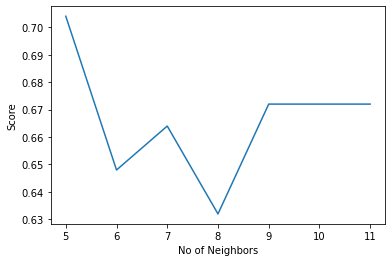

Best score = 0.704
 Neighbors = 5


In [23]:

scores = []

for i in range(5, 12):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds)
    scores.append(accuracy)

plt.plot(np.arange(5, 12), scores)
plt.xlabel('No of Neighbors')
plt.ylabel('Score')
plt.show()

best_neighbors = np.arange(5, 12)[scores.index(max(scores))]
print('Best score = {}\n Neighbors = {}'.format(max(scores), best_neighbors))

In [24]:

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=2)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print('Accuracy Score: {:0.4f}'.format(accuracy_score(y_test, rf_preds)))


Accuracy Score: 0.7920


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


params = {'min_samples_split':[1,2,3]}

dt = DecisionTreeClassifier()

grid = GridSearchCV(dt, param_grid=params, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

{'min_samples_split': 2}
0.7546666666666667


In [50]:
from sklearn.model_selection import GridSearchCV

logistic = XGBClassifier(
    learning_rate =0.002,
    n_estimators=1000,
    max_depth=6,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.69,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    reg_alpha=1e-5,
    seed=10)

logistic.fit(X_train, y_train)
logistic_pd = logistic.predict(X_test)
print('Accuracy Score: {:0.4f}'.format(accuracy_score(y_test, logistic_pd)))

# params = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

# grid = GridSearchCV(logistic, param_grid=params, scoring='accuracy', cv=5)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_score_)

[17:24:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score: 0.8240
